In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow

In [2]:
df = pd.read_csv('PV_Live.csv')
df.head()

,date,time,generation_mw,lcl_mw,ucl_mw,installedcapacity_mwp,capacity_mwp
0,18-04-2024,15:30:00,3508.04,3380.27,3635.81,16445.201,15430.445
1,18-04-2024,15:00:00,4253.15,4117.64,4388.65,16445.201,15430.445
2,18-04-2024,14:30:00,4993.39,4847.18,5139.59,16445.201,15430.446
3,18-04-2024,14:00:00,5664.35,5508.08,5820.61,16445.201,15430.446
4,18-04-2024,13:30:00,6227.09,6061.42,6392.76,16445.201,15430.446


In [3]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [4]:
train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)

In [5]:
print(train_size)

12286


In [6]:
print(val_size)

2632


In [7]:
train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

In [8]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['generation_mw', 'lcl_mw', 'ucl_mw', 'installedcapacity_mwp']])
val_scaled = scaler.transform(val_data[['generation_mw', 'lcl_mw', 'ucl_mw', 'installedcapacity_mwp']])
test_scaled = scaler.transform(test_data[['generation_mw', 'lcl_mw', 'ucl_mw', 'installedcapacity_mwp']])

In [9]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [10]:
seq_length = 10  # Adjust as needed
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [11]:
model =  Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1, activation='relu')
])

c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [13]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/50
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1186 - mae: 0.2786
Epoch 1: val_loss improved from inf to 0.05386, saving model to best_model.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1186 - mae: 0.2785 - val_loss: 0.0539 - val_mae: 0.1547
Epoch 2/50
378/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1116 - mae: 0.2655
Epoch 2: val_loss improved from 0.05386 to 0.05362, saving model to best_model.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1116 - mae: 0.2655 - val_loss: 0.0536 - val_mae: 0.1543
Epoch 3/50
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1111 - mae: 0.2638
Epoch 3: val_loss improved from 0.05362 to 0.05360, saving model to best_model.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1111 - mae: 0.2638 - val_loss: 0.0536 - val_mae: 0.1510
Epoch 4/50
378/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1106 - mae: 0.2632
Epoch 4: val_loss improved from 0.05360 to 0.05352, saving model to best_model.keras
384/384 ━━━━━━━━━━━

In [15]:
best_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1, activation='relu')
])


In [16]:
best_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [18]:
best_model.load_weights('best_model.keras')

c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [19]:
train_loss, train_mae = best_model.evaluate(X_train, y_train, verbose=0)
print(f'Training Loss: {train_loss}, Training MAE: {train_mae}')



Training Loss: 0.11116355657577515, Training MAE: 0.2632865607738495


In [20]:
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Testing Loss: {test_loss}, Testing MAE: {test_mae}')


Testing Loss: nan, Testing MAE: nan


In [21]:
val_loss, val_mae = best_model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {val_loss}, Validation MAE: {val_mae}')

Validation Loss: 0.0534389466047287, Validation MAE: 0.1515727937221527


In [22]:
train_predictions = best_model.predict(X_train).flatten()
val_predictions = best_model.predict(X_val).flatten()
test_predictions = best_model.predict(X_test).flatten()

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [51]:
dates_train = pd.date_range(start='2023-05-01', periods=len(train_predictions), freq='D')
dates_val = pd.date_range(start='2024-01-01', periods=len(val_predictions), freq='D')
dates_test = pd.date_range(start='2023-09-01', periods=len(test_predictions), freq='D')

In [52]:
def plot_time_series(dates, predictions, observations, title):
    plt.plot(dates, predictions)
    plt.legend(['Predictions', 'Observations'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Capacity (mwp)')  # Adjust ylabel as needed
    plt.xticks(rotation=45)
    plt.show()


In [53]:
def plot_time_series(dates, predictions, observations, title):
    plt.plot(dates, observations)
    plt.legend(['Predictions', 'Observations'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Capacity (mwp)')  # Adjust ylabel as needed
    plt.xticks(rotation=45)
    plt.show()


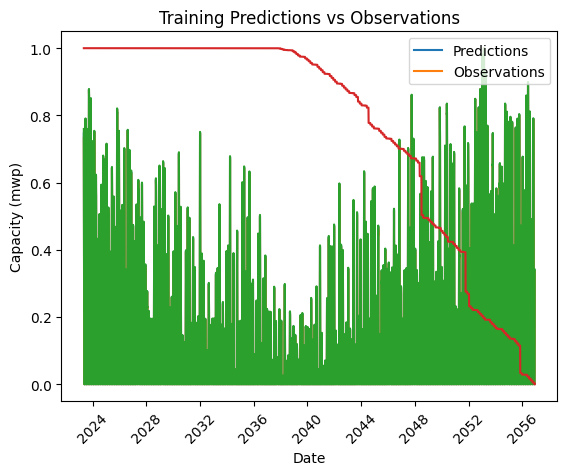

In [54]:
plot_time_series(dates_train, train_predictions, y_train, 'Training Predictions vs Observations')

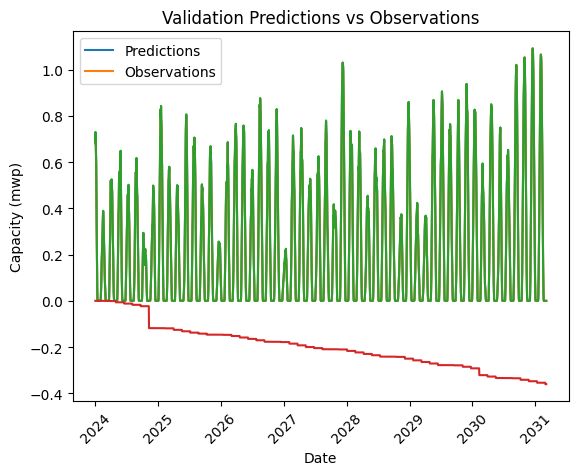

In [55]:
plot_time_series(dates_val, val_predictions, y_val, 'Validation Predictions vs Observations')

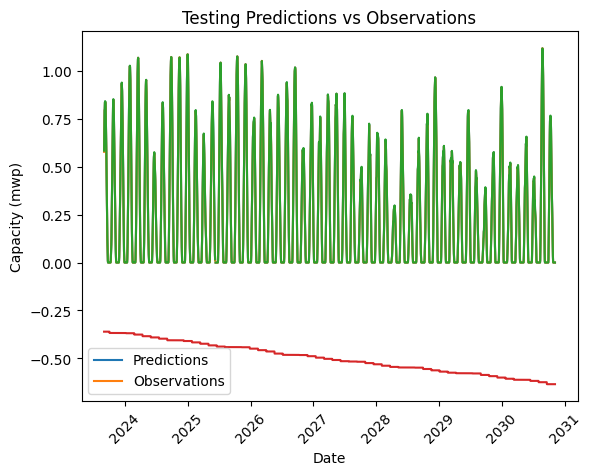

In [56]:
plot_time_series(dates_test, test_predictions, y_test, 'Testing Predictions vs Observations')